# Solution using `FEniCSx`

In [1]:
from dolfinx import default_scalar_type, fem, mesh
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import ufl

## Define mesh and function space

We can use the module `dolfinx.mesh` to create geometries and meshes. Then we define the function space `V` of P1 (piecewise linear) continuous elements.

In [2]:
Omega = mesh.create_interval(MPI.COMM_WORLD, 100, [0, 1])
V = fem.functionspace(Omega, ('Lagrange', 1))
V0 = fem.functionspace(Omega, ('DG', 0))

Then we define a trial function `u` (i.e., the solution) and a test function `v`.

In [3]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Dirichlet boundary conditions

Boundary conditions in `FEniCSx` are lists of `DirichletBC` objects defined by specifying the value (e.g., `default_scalar_type(0)` is the float `0`) on the set of points (e.g., `dofs_L`) where the boundary condition is defined (e.g., `np. isclose(x[0], 0)`).

In [4]:
dofs_L = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
dofs_R = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
bc_L = fem.dirichletbc(default_scalar_type(0), dofs_L, V)
bc_R = fem.dirichletbc(default_scalar_type(10), dofs_R, V)
bcs = [bc_L, bc_R]

## Define parameter

First we define the two different subdomains.

In [5]:
def Omega_0(x):
    return x[0] <= 0.5

def Omega_1(x):
    return x[0] >= 0.5

Then we take the function `a` and we assign different values depending on the subdomain.

In [6]:
sigma = fem.Function(V0)

cells_0 = mesh.locate_entities(Omega, Omega.topology.dim, Omega_0)
cells_1 = mesh.locate_entities(Omega, Omega.topology.dim, Omega_1)

sigma.x.array[cells_0] = np.full_like(cells_0, 1, dtype=default_scalar_type)
sigma.x.array[cells_1] = np.full_like(cells_1, 2, dtype=default_scalar_type)

## Weak formulation

We define the operators of the weak formulation in the following way.

In [7]:
a = ufl.inner(sigma * ufl.grad(u), ufl.grad(v)) * ufl.dx
L = fem.Constant(Omega, default_scalar_type(0)) * v * ufl.dx

Then we define the variational problem and we solve it.

In [8]:
problem = LinearProblem(a, L, bcs=bcs)#, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u = problem.solve()

## Comparison with analytic solution

In [9]:
y = fem.Function(V)
I = Omega.geometry.x[:,0]
y.x.array[:] = np.where(I < 0.5, I * 40 / 3, I * 20 / 3 + 10 / 3)
L2_error = fem.assemble_scalar(fem.form(ufl.inner(u - y, u - y) * ufl.dx))
L2_error

2.38704710323707e-27

## Plotting

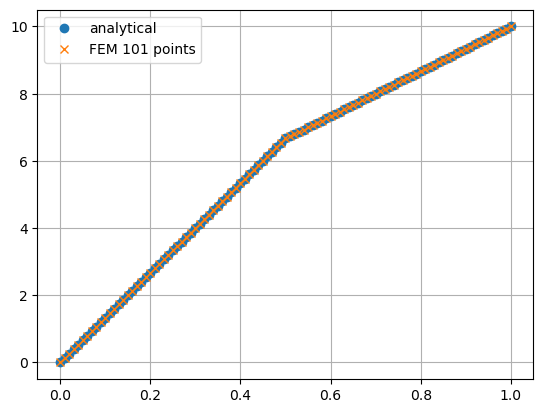

In [10]:
plt.plot(I, y.x.array, "o", label="analytical")
plt.plot(I, u.x.array, "x", label="FEM 101 points")
plt.legend()
plt.grid()
plt.show()

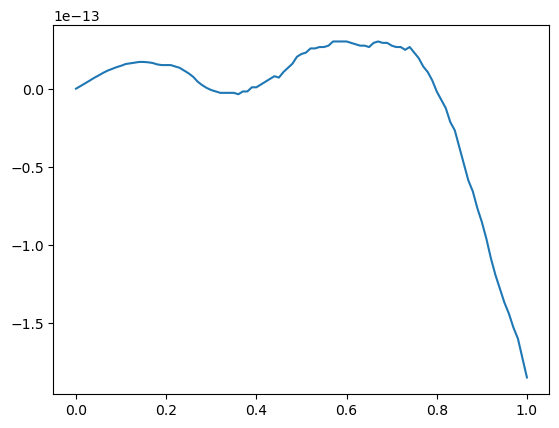

In [11]:
plt.plot(I, y.x.array - u.x.array)